In [318]:
import os
import sys
import time
import yaml
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from typing import Tuple, List, Dict, Callable, Iterable
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import (
    train_test_split,
    learning_curve,
    cross_val_score,
    cross_validate,
    GridSearchCV
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    f1_score
)

sys.path.append(os.path.join('..', 'src'))

from sentiment_analysis.core.preprocessing import TextPreprocessor

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/imilyutin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/imilyutin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/imilyutin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/imilyutin/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/imilyutin/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
warnings.filterwarnings('ignore')
plt.style.use('seaborn')

In [173]:
def plot_learning_curve(
    train_size: np.array,
    train_score: np.ndarray,
    val_score: np.ndarray,
    metric_nm: str = 'Accuracy',
    title: str = 'Learning curve'
):
    train_score_mean = train_score.mean(axis=1)
    train_score_std = train_score.std(axis=1)
    val_score_mean = val_score.mean(axis=1)
    val_score_std = val_score.std(axis=1)
    plt.plot(train_size, train_score.mean(axis=1), label='Train score')
    plt.fill_between(
        train_size,
        train_score_mean - train_score_std,
        train_score_mean + train_score_std,
        alpha=0.1,
    )
    plt.plot(train_size, val_score.mean(axis=1), label='Validation score')
    plt.fill_between(
        train_size,
        val_score_mean - val_score_std,
        val_score_mean + val_score_std,
        alpha=0.1,
    )
    plt.legend(loc='best')
    plt.xlabel('Train size')
    plt.ylabel(metric_nm)
    plt.title(title)
    plt.show()

In [3]:
credentials_file = os.path.abspath(os.path.join('..', 'credentials.yaml'))
with open(credentials_file, 'r') as f:
    credentials = yaml.safe_load(f)

storage_options = {
    'key': credentials['aws']['access_key'],
    'secret': credentials['aws']['secret_access_key']
}

In [4]:
partition_uri = f's3://{credentials["aws"]["bucket"]}/reviews/reviews_partition_1.csv'
partition = pd.read_csv(
    partition_uri,
    compression='gzip',
    storage_options=storage_options,
    usecols=['text', 'rating', 'total_votes']
)
partition['positive'] = partition['rating'] > 5
partition = partition[~partition['rating'].isna()].drop('rating', axis=1)

mem = partition.memory_usage(deep=True).sum()/1024/1024
print('Number of reviews:', len(partition))
print(f'Memory usage: {mem:.1f} Mb')
partition.head()

Number of reviews: 220873
Memory usage: 249.0 Mb


,text,total_votes,positive
0,"Chucky (the murderous doll from ""Child's Play""...",40,True
1,"They obviously made ""Bride of Chucky"" with the...",20,True
2,Well my opinion has changed for this one becau...,22,True
3,Clever is the word that comes to mind when I t...,15,True
4,Realizing he needs to turn back into human for...,15,True


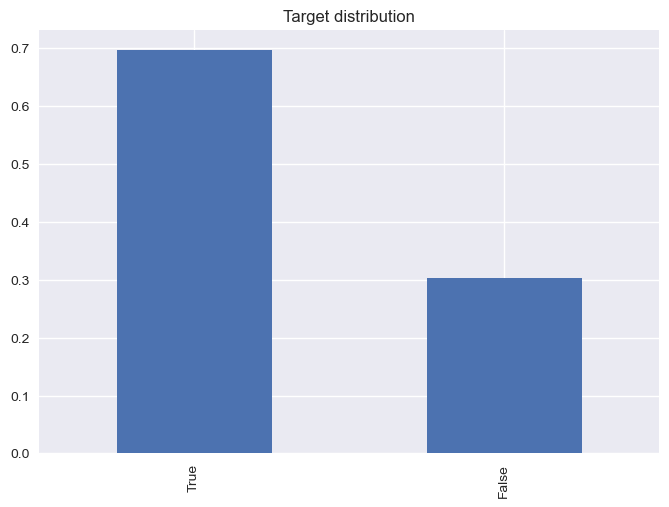

In [353]:
partition['positive'].value_counts(normalize=True).plot(
    kind='bar', title='Target distribution'
)
plt.show()

In [5]:
partition_sample = (
    partition
    .sort_values(['positive', 'total_votes'])
    .groupby('positive')
    .tail(20000)
)

preprocessor = TextPreprocessor()
partition_sample['processed_text'] = partition_sample['text'].apply(preprocessor._transform)
partition_sample.head()

,text,total_votes,positive,processed_text
132565,"Uhm, no. This was just cartoonish and silly. I...",14,False,uhm cartoonish silly certainly aim young demog...
132831,The final twist will probably be the final str...,14,False,final twist probably final straw manage weathe...
132847,Visually 'Renaissance' proves to be an interes...,14,False,visually renaissance prove interesting time br...
132867,I kept waiting for these great graphics as in ...,14,False,keep wait great graphic reviewer comment far t...
133035,I'll preface this review by saying I'm a strai...,14,False,preface review say straight guy obviously know...


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    partition_sample['processed_text'],
    partition_sample['positive'],
    train_size=0.8
)

In [7]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=2000)
tfidf_mat = vectorizer.fit_transform(X_train)
tfidf_mat.shape

(32000, 2000)

# Comparison of models with default hyperparameters

In [12]:
models = {
    'logreg': LogisticRegression(max_iter=1000),
    'tree': DecisionTreeClassifier(max_depth=5),
    'rf': RandomForestClassifier(max_depth=5),
    'knn': KNeighborsClassifier(),
    'nb': MultinomialNB()
}
models_results = {}
for model_nm, model in models.items():
    print(f'Cross-validating {model_nm} model')
    s = time.time()
    models_results[model_nm] = cross_validate(
        model,
        tfidf_mat,
        y_train,
        scoring=['accuracy', 'f1'],
        return_train_score=True
    )
    e = time.time()
    print(f'Completed in {(e - s):.1f} seconds')

Cross-validating logreg model
Completed in 1.8 seconds
Cross-validating tree model
Completed in 4.4 seconds
Cross-validating rf model
Completed in 9.1 seconds
Cross-validating knn model
Completed in 202.9 seconds
Cross-validating nb model
Completed in 0.2 seconds


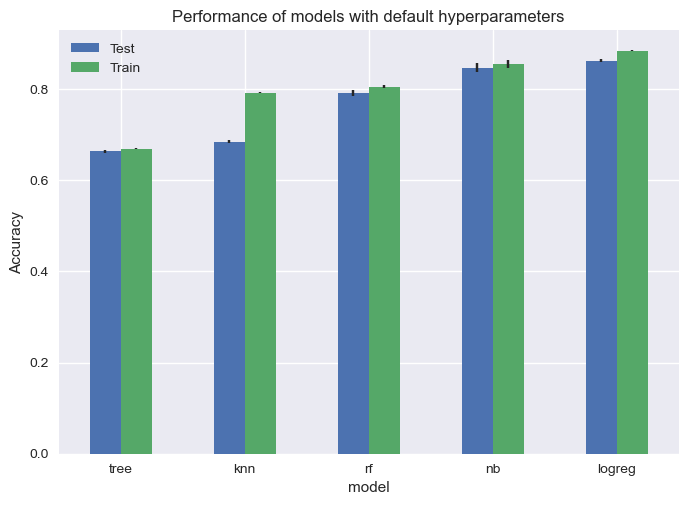

In [32]:
cv_df = pd.DataFrame({
    'model': models_results.keys(),
    'test_accuracy_mean': [
        res['test_accuracy'].mean()
        for res in models_results.values()
    ],
    'test_accuracy_std': [
        res['test_accuracy'].std()
        for res in models_results.values()
    ],
    'train_accuracy_mean': [
        res['train_accuracy'].mean()
        for res in models_results.values()
    ],
    'train_accuracy_std': [
        res['train_accuracy'].std()
        for res in models_results.values()
    ]
})
cv_df_mean = (
    cv_df[['model', 'test_accuracy_mean', 'train_accuracy_mean']]
    .set_index('model')
    .sort_values('test_accuracy_mean', ascending=True)
)
cv_df_mean.plot(
    kind='bar',
    ylabel='Accuracy',
    title='Performance of models with default hyperparameters',
    yerr=[cv_df['test_accuracy_std'], cv_df['train_accuracy_std']]
)
plt.legend(labels=['Test', 'Train'], loc='best')
plt.xticks(rotation=0)
plt.show()

### Candidates models:
* Logistic Regression:
    * Pros: Fast on training and prediction, good performance, few hyperparameters
    * Cons: More feature engineering needs to be done
* Naive Bayes:
    * Pros: Few hyperparameters, good performance, fast on prediction
    * Cons: More feature engineering needs to be done
* Random Forest:
    * Pros: Fast on prediction and quite accurate, has a potential (though it's not guaranteed) to outperform other models due
    * Cons: Many hyperparameters to tune, so tuning process could lasts long

# Tuning pipeline with Logistic Regression Model 

### Tuning TF-IDF Vectorizer

In [181]:
logreg_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('logreg', LogisticRegression(max_iter=500))
])
logreg_param_grid = {
    'tfidf__sublinear_tf': [True, False],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__max_features': [
        500, 1000, 1500, 2000, 3000,
        4000, 5000, 7500, 10000, 15000, 20000
    ],
    'logreg__C': [0.1, 0.5, 1, 3, 5]
}
logreg_gs = GridSearchCV(
    logreg_pipeline,
    logreg_param_grid,
    n_jobs=-1,
    verbose=2,
    scoring='accuracy',
    return_train_score=True
)
logreg_gs.fit(X_train, y_train)

Fitting 5 folds for each of 220 candidates, totalling 1100 fits
[CV] END logreg__C=0.1, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__sublinear_tf=True; total time=   3.2s
[CV] END logreg__C=0.1, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__sublinear_tf=True; total time=   3.3s
[CV] END logreg__C=0.1, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__sublinear_tf=False; total time=   3.3s
[CV] END logreg__C=0.1, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__sublinear_tf=True; total time=   3.6s
[CV] END logreg__C=0.1, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__sublinear_tf=True; total time=   3.4s
[CV] END logreg__C=0.1, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__sublinear_tf=True; total time=   3.4s
[CV] END logreg__C=0.1, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__sublinear_tf=False; total time=   3.7s
[CV] END logreg__C=0.1, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__subl

GridSearchCV(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('logreg',
                                        LogisticRegression(max_iter=500))]),
             n_jobs=-1,
             param_grid={'logreg__C': [0.1, 0.5, 1, 3, 5],
                         'tfidf__max_features': [500, 1000, 1500, 2000, 3000,
                                                 4000, 5000, 7500, 10000, 15000,
                                                 20000],
                         'tfidf__ngram_range': [(1, 1), (1, 2)],
                         'tfidf__sublinear_tf': [True, False]},
             return_train_score=True, scoring='accuracy', verbose=2)

In [184]:
usecols = [
    'mean_test_score',
    'std_test_score',
    'mean_train_score',
    'std_train_score'
]
params = [
    {k.split('__')[1]: v for k, v in p.items()}
    for p in logreg_gs.cv_results_['params']
]
logreg_gs_df = pd.DataFrame(
    data={c: logreg_gs.cv_results_[c] for c in usecols},
    index=params
)
logreg_gs_df = logreg_gs_df.reset_index().rename({'index': 'params'}, axis=1)
logreg_gs_df[['C', 'max_features', 'ngram_range', 'sublinear_df']] = (
    logreg_gs_df
    ['params']
    .apply(pd.Series)
)
logreg_gs_df = logreg_gs_df.sort_values('mean_test_score', ascending=False)
logreg_gs_df.head()

,params,mean_test_score,std_test_score,mean_train_score,std_train_score,C,max_features,ngram_range,sublinear_df
130,"{'C': 1, 'max_features': 20000, 'ngram_range':...",0.877531,0.002844,0.924609,0.000881,1.0,20000,"(1, 2)",True
174,"{'C': 3, 'max_features': 20000, 'ngram_range':...",0.877125,0.002969,0.951023,0.000832,3.0,20000,"(1, 2)",True
126,"{'C': 1, 'max_features': 15000, 'ngram_range':...",0.876812,0.003090,0.921672,0.000889,1.0,15000,"(1, 2)",True
170,"{'C': 3, 'max_features': 15000, 'ngram_range':...",0.876437,0.002173,0.946055,0.000885,3.0,15000,"(1, 2)",True
175,"{'C': 3, 'max_features': 20000, 'ngram_range':...",0.875437,0.002195,0.947734,0.001087,3.0,20000,"(1, 2)",False


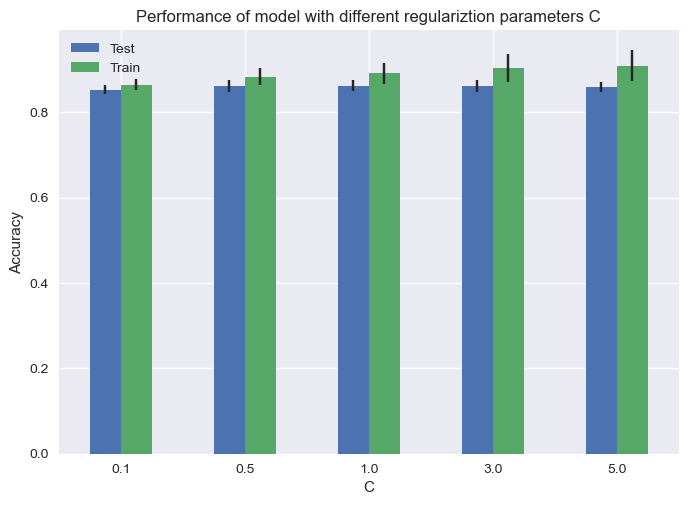

In [225]:
accuracy_by_c = (
    logreg_gs_df
    .groupby('C')
    .agg({
        'mean_test_score': ['mean', 'std'],
        'mean_train_score': ['mean', 'std']
    })
)
accuracy_by_c_mean = accuracy_by_c[[
    ('mean_test_score', 'mean'),
    ('mean_train_score', 'mean')
]].droplevel(1, axis=1)
accuracy_by_c_std = accuracy_by_c[[
    ('mean_test_score', 'std'),
    ('mean_train_score', 'std')
]].droplevel(1, axis=1)

accuracy_by_c_mean.plot(
    kind='bar',
    ylabel='Accuracy',
    title='Performance of model with different regulariztion parameters C',
    yerr=[
        accuracy_by_c_std['mean_test_score'],
        accuracy_by_c_std['mean_train_score']
    ]
)
plt.legend(labels=['Test', 'Train'], loc='best')
plt.xticks(rotation=0)
plt.show()

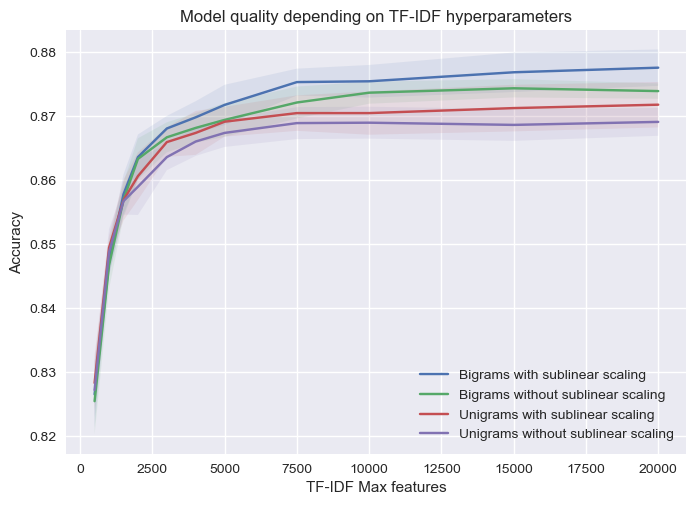

In [232]:
bigrams_sublinear = logreg_gs_df[
    (logreg_gs_df['ngram_range'] == (1, 2))
    & (logreg_gs_df['sublinear_df'] == True)
    & (logreg_gs_df['C'] == 1)
].set_index('max_features').sort_index()
unigrams_sublinear = logreg_gs_df[
    (logreg_gs_df['ngram_range'] == (1, 1))
    & (logreg_gs_df['sublinear_df'] == True)
    & (logreg_gs_df['C'] == 1)
].set_index('max_features').sort_index()
bigrams_nsublinear = logreg_gs_df[
    (logreg_gs_df['ngram_range'] == (1, 2))
    & (logreg_gs_df['sublinear_df'] == False)
    & (logreg_gs_df['C'] == 1)
].set_index('max_features').sort_index()
unigrams_nsublinear = logreg_gs_df[
    (logreg_gs_df['ngram_range'] == (1, 1))
    & (logreg_gs_df['sublinear_df'] == False)
    & (logreg_gs_df['C'] == 1)
].set_index('max_features').sort_index()

plt.plot(bigrams_sublinear['mean_test_score'], label='Bigrams with sublinear scaling')
plt.fill_between(
    bigrams_sublinear.index,
    bigrams_sublinear['mean_test_score'] - bigrams_sublinear['std_test_score'],
    bigrams_sublinear['mean_test_score'] + bigrams_sublinear['std_test_score'],
    alpha=0.1,
)
plt.plot(bigrams_nsublinear['mean_test_score'], label='Bigrams without sublinear scaling')
plt.fill_between(
    bigrams_nsublinear.index,
    bigrams_nsublinear['mean_test_score'] - bigrams_nsublinear['std_test_score'],
    bigrams_nsublinear['mean_test_score'] + bigrams_nsublinear['std_test_score'],
    alpha=0.1,
)
plt.plot(unigrams_sublinear['mean_test_score'], label='Unigrams with sublinear scaling')
plt.fill_between(
    unigrams_sublinear.index,
    unigrams_sublinear['mean_test_score'] - unigrams_sublinear['std_test_score'],
    unigrams_sublinear['mean_test_score'] + unigrams_sublinear['std_test_score'],
    alpha=0.1,
)
plt.plot(unigrams_nsublinear['mean_test_score'], label='Unigrams without sublinear scaling')
plt.fill_between(
    unigrams_nsublinear.index,
    unigrams_nsublinear['mean_test_score'] - unigrams_nsublinear['std_test_score'],
    unigrams_nsublinear['mean_test_score'] + unigrams_nsublinear['std_test_score'],
    alpha=0.1,
)
plt.legend(loc='best')
plt.ylabel('Accuracy')
plt.xlabel('TF-IDF Max features')
plt.title('Model quality depending on TF-IDF hyperparameters')
plt.show()

We certainly need to use bigrams and sublinear scaling, because for each number of tf-idf features accuracy is higher than other combinations of hyperparameters. If we talk about max_features hyperparameter of tf-idf vectorizer here we can pick suboptimal value 7500 features, because the curve reaches a plateau and after certain value accuracy doesn't improve

In [233]:
tfidf_optimal_params = {
    'ngram_range': (1, 2),
    'max_features': 7500,
    'sublinear_tf': True
}

In [179]:
logreg_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_optimal_params)),
    ('logreg', LogisticRegression(max_iter=500))
])

train_size, train_score, val_score = learning_curve(
    logreg_pipeline,
    X_train,
    y_train,
    train_sizes=np.linspace(0.3, 1, 70),
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

[learning_curve] Training set sizes: [ 7680  7939  8199  8459  8718  8978  9238  9497  9757 10017 10277 10536
 10796 11056 11315 11575 11835 12095 12354 12614 12874 13133 13393 13653
 13913 14172 14432 14692 14951 15211 15471 15731 15990 16250 16510 16769
 17029 17289 17548 17808 18068 18328 18587 18847 19107 19366 19626 19886
 20146 20405 20665 20925 21184 21444 21704 21964 22223 22483 22743 23002
 23262 23522 23782 24041 24301 24561 24820 25080 25340 25600]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[CV] END .................................................... total time=   5.7s
[CV] END .................................................... total time=   6.5s
[CV] END .................................................... total time=   6.5s
[CV] END .................................................... total time=   6.7s
[CV] END .................................................... total time=   6.8s
[CV] END .................................................... total time=   6.8s
[CV] END .................................................... total time=   6.9s
[CV] END .................................................... total time=   6.9s
[CV] END .................................................... total time=   7.3s
[CV] END .................................................... total time=   8.0s
[CV] END .................................................... total time=   8.2s
[CV] END .................................................... total time=   7.9s
[CV] END ...................

[Parallel(n_jobs=-1)]: Done 175 out of 350 | elapsed:  6.3min remaining:  6.3min


[CV] END .................................................... total time=  13.7s
[CV] END .................................................... total time=  14.0s
[CV] END .................................................... total time=  14.0s
[CV] END .................................................... total time=  14.6s
[CV] END .................................................... total time=  14.4s
[CV] END .................................................... total time=  14.8s
[CV] END .................................................... total time=  15.1s
[CV] END .................................................... total time=  15.4s
[CV] END .................................................... total time=  15.2s
[CV] END .................................................... total time=  16.0s
[CV] END .................................................... total time=  15.6s
[CV] END .................................................... total time=  16.2s
[CV] END ...................

[Parallel(n_jobs=-1)]: Done 350 out of 350 | elapsed: 13.4min finished


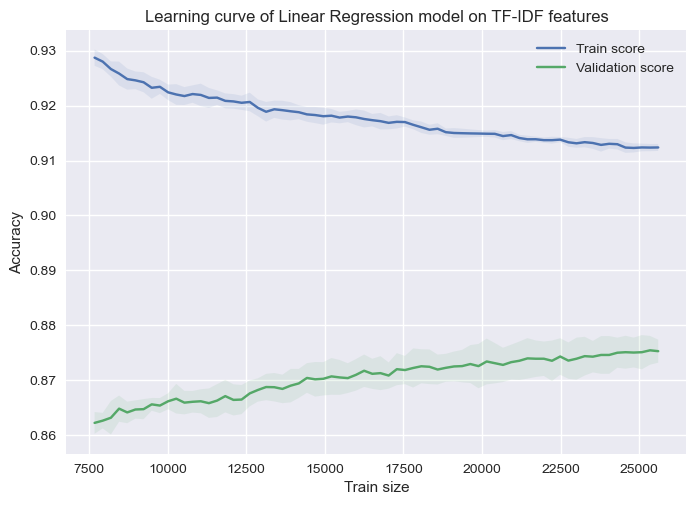

In [180]:
plot_learning_curve(
    train_size,
    train_score,
    val_score,
    title='Learning curve of Linear Regression model on TF-IDF features'
)

### Tuning SVD

In [165]:
n_components = [100, 500, 1000, 1500, 2000, 2500, 3000, 5000]
explained_variance = []
for n in tqdm(n_components):
    logreg_svd_pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(**tfidf_optimal_params)),
        ('svd', TruncatedSVD(n))
    ])
    logreg_svd_pipeline.fit(X_train)
    var = logreg_svd_pipeline['svd'].explained_variance_ratio_.sum()
    explained_variance.append(var)

100%|██████████| 8/8 [15:49<00:00, 118.63s/it]


In [235]:
svd_param_grid = {
    'svd__n_components': [100, 500, 1000, 1500, 2000, 3000]
}

logreg_svd_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_optimal_params)),
    ('svd', TruncatedSVD()),
    ('logreg', LogisticRegression(max_iter=500))    
])

svd_gs = GridSearchCV(
    logreg_svd_pipeline,
    svd_param_grid,
    n_jobs=4,
    verbose=1,
    scoring='accuracy',
    return_train_score=True
)
svd_gs.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_features=7500,
                                                        ngram_range=(1, 2),
                                                        sublinear_tf=True)),
                                       ('svd', TruncatedSVD()),
                                       ('logreg',
                                        LogisticRegression(max_iter=500))]),
             n_jobs=4,
             param_grid={'svd__n_components': [100, 500, 1000, 1500, 2000,
                                               3000]},
             return_train_score=True, scoring='accuracy', verbose=1)

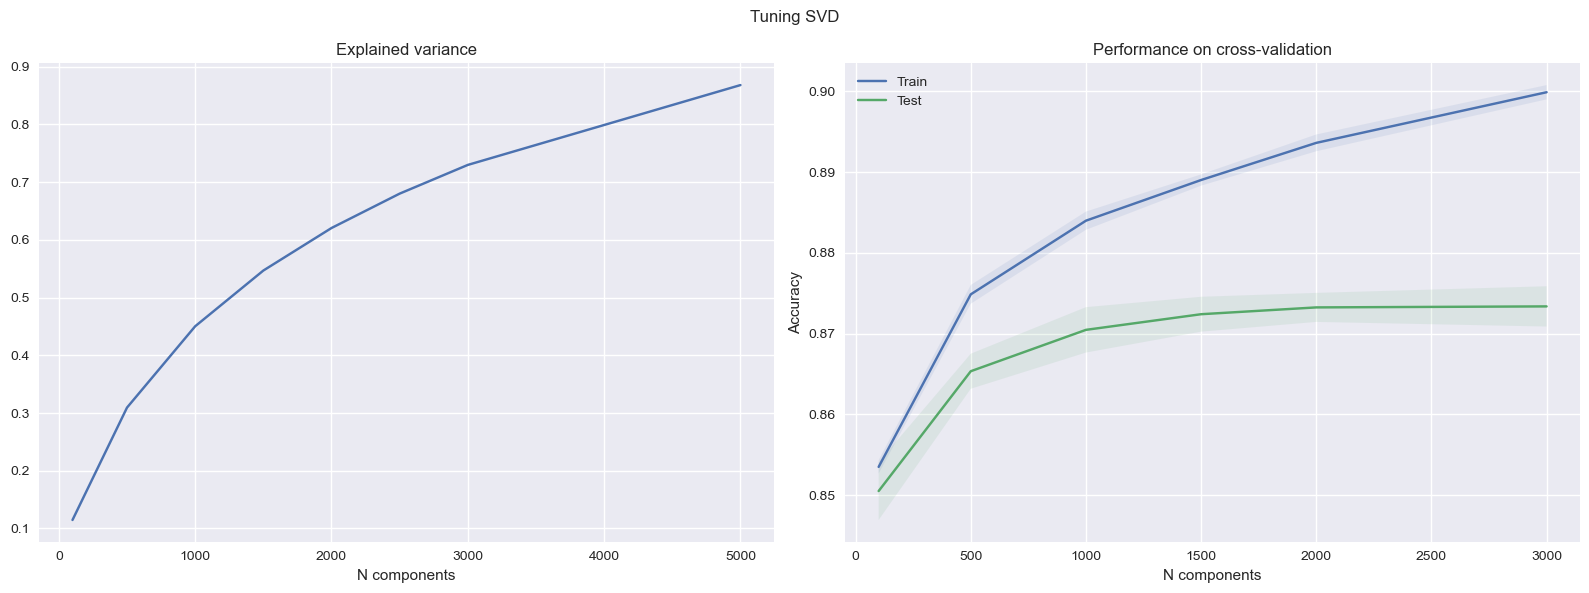

In [255]:
fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(16, 6))
fig.suptitle('Tuning SVD')

ax[0].plot(n_components, explained_variance)
ax[0].set_xlabel('N components')
ax[0].set_title('Explained variance')
ax[1].plot(
    svd_param_grid['svd__n_components'],
    svd_gs.cv_results_['mean_train_score'],
    label='Train'
)
ax[1].fill_between(
    svd_param_grid['svd__n_components'],
    svd_gs.cv_results_['mean_train_score'] - svd_gs.cv_results_['std_train_score'],
    svd_gs.cv_results_['mean_train_score'] + svd_gs.cv_results_['std_train_score'],
    alpha=0.1
)
ax[1].plot(
    svd_param_grid['svd__n_components'],
    svd_gs.cv_results_['mean_test_score'],
    label='Test'
)
ax[1].fill_between(
    svd_param_grid['svd__n_components'],
    svd_gs.cv_results_['mean_test_score'] - svd_gs.cv_results_['std_test_score'],
    svd_gs.cv_results_['mean_test_score'] + svd_gs.cv_results_['std_test_score'],
    alpha=0.1
)
ax[1].legend(loc='best')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('N components')
ax[1].set_title('Performance on cross-validation')

plt.show()

# Tuning Random Forest

In [258]:
rf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_optimal_params)),
    ('rf', RandomForestClassifier())
])
rf_grid = {
    'rf__max_depth': [2, 3, 4, 5],
    'rf__min_samples_leaf': [1, 2],
    'rf__min_samples_split': [2, 4]
}
rf_gs = GridSearchCV(
    rf_pipeline,
    rf_grid,
    n_jobs=-1,
    verbose=2,
    scoring='accuracy',
    return_train_score=True
)
rf_gs.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END rf__max_depth=2, rf__min_samples_leaf=1, rf__min_samples_split=2; total time=  16.6s
[CV] END rf__max_depth=2, rf__min_samples_leaf=1, rf__min_samples_split=2; total time=  17.0s
[CV] END rf__max_depth=2, rf__min_samples_leaf=1, rf__min_samples_split=2; total time=  17.2s
[CV] END rf__max_depth=2, rf__min_samples_leaf=1, rf__min_samples_split=4; total time=  17.0s
[CV] END rf__max_depth=2, rf__min_samples_leaf=1, rf__min_samples_split=4; total time=  16.9s
[CV] END rf__max_depth=2, rf__min_samples_leaf=1, rf__min_samples_split=2; total time=  17.9s
[CV] END rf__max_depth=2, rf__min_samples_leaf=1, rf__min_samples_split=4; total time=  17.3s
[CV] END rf__max_depth=2, rf__min_samples_leaf=1, rf__min_samples_split=2; total time=  17.9s
[CV] END rf__max_depth=2, rf__min_samples_leaf=1, rf__min_samples_split=4; total time=  18.1s
[CV] END rf__max_depth=2, rf__min_samples_leaf=2, rf__min_samples_split=2; total time=  17.7s

GridSearchCV(estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_features=7500,
                                                        ngram_range=(1, 2),
                                                        sublinear_tf=True)),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [2, 3, 4, 5],
                         'rf__min_samples_leaf': [1, 2],
                         'rf__min_samples_split': [2, 4]},
             return_train_score=True, scoring='accuracy', verbose=2)

# Tuning Naive Bayes

In [261]:
nb_param_grid = {
    'nb__alpha': [0.1, 0.5, 1, 5, 10]
}

nb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_optimal_params)),
    ('nb', MultinomialNB())    
])

nb_gs = GridSearchCV(
    nb_pipeline,
    nb_param_grid,
    n_jobs=-1,
    verbose=1,
    scoring='accuracy',
    return_train_score=True
)
nb_gs.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_features=7500,
                                                        ngram_range=(1, 2),
                                                        sublinear_tf=True)),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1, param_grid={'nb__alpha': [0.1, 0.5, 1, 5, 10]},
             return_train_score=True, scoring='accuracy', verbose=1)

# Comparison of tuned models

In [267]:
logreg_best = logreg_gs.best_estimator_
logreg_score = cross_validate(
    logreg_best,
    X_train,
    y_train,
    scoring='accuracy',
    return_train_score=True
)

In [338]:
logreg_val_score = logreg_score['test_score'].mean()
logreg_train_score = logreg_score['train_score'].mean()
logreg_test_score = accuracy_score(y_test, logreg_best.predict(X_test))
logreg_report = classification_report(y_test, logreg_best.predict(X_test))

print(f'Accuracy of tuned Logistic Regression on validation set: {logreg_val_score:.3f}')
print(f'Accuracy of tuned Logistic Regression on test set: {logreg_test_score:.3f}')
print(logreg_report)

Accuracy of tuned Logistic Regression on validation set: 0.878
Accuracy of tuned Logistic Regression on test set: 0.870
              precision    recall  f1-score   support

       False       0.88      0.86      0.87      4029
        True       0.86      0.88      0.87      3971

    accuracy                           0.87      8000
   macro avg       0.87      0.87      0.87      8000
weighted avg       0.87      0.87      0.87      8000



In [ ]:
rf_best = rf_gs.best_estimator_
rf_score = cross_validate(
    rf_best,
    X_train,
    y_train,
    scoring='accuracy',
    return_train_score=True
)

In [337]:
rf_val_score = rf_score['test_score'].mean()
rf_train_score = rf_score['train_score'].mean()
rf_test_score = accuracy_score(y_test, rf_best.predict(X_test))
rf_report = classification_report(y_test, rf_best.predict(X_test))

print(f'Accuracy of tuned Random Forest on validation set: {rf_val_score:.3f}')
print(f'Accuracy of tuned Random Forest on test set: {rf_test_score:.3f}')
print(rf_report)

Accuracy of tuned Random Forest on validation set: 0.797
Accuracy of tuned Random Forest on test set: 0.795
              precision    recall  f1-score   support

       False       0.81      0.78      0.79      4029
        True       0.78      0.81      0.80      3971

    accuracy                           0.80      8000
   macro avg       0.80      0.80      0.80      8000
weighted avg       0.80      0.80      0.80      8000



In [275]:
nb_best = nb_gs.best_estimator_
nb_score = cross_validate(
    nb_best,
    X_train,
    y_train,
    scoring='accuracy',
    return_train_score=True
)

In [336]:
nb_val_score = nb_score['test_score'].mean()
nb_train_score = nb_score['train_score'].mean()
nb_test_score = accuracy_score(y_test, nb_best.predict(X_test))
nb_report = classification_report(y_test, nb_best.predict(X_test))

print(f'Accuracy of tuned Naive Bayes on validation set: {nb_val_score:.3f}')
print(f'Accuracy of tuned Naive Bayes on test set: {nb_test_score:.3f}')
print(nb_report)

Accuracy of tuned Naive Bayes on validation set: 0.865
Accuracy of tuned Naive Bayes on test set: 0.860
              precision    recall  f1-score   support

       False       0.87      0.85      0.86      4029
        True       0.85      0.87      0.86      3971

    accuracy                           0.86      8000
   macro avg       0.86      0.86      0.86      8000
weighted avg       0.86      0.86      0.86      8000



Tuned Logistic Regression on TF-IDF features is the best model!